## SQAE with DRC 

Trying the Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time

import warnings
warnings.filterwarnings('ignore')

2022-08-15 16:30:37.137926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 16:30:37.137944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Circuit

In [9]:
DATA_QBITS = 4
LATENT_QBITS = 2
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1
DRCs = 1

INPUT_DATA_SIZE = 1

In [10]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [14]:
def single_upload(params, data, wire):
    qml.RX(params[0] + params[1]*data[0], wires=wire)
    #qml.RY(params[2] + params[3]*data[1], wires=wire)
    #qml.RZ(params[4] + params[5]*data[2], wires=wire)

def full_data_layer(params, data, wire):
    pad = 3 - data.shape[0] % 3
    padded_data = qml.math.concatenate([data, np.zeros(pad)])
    for i in range(padded_data.shape[0] // 3):
        single_upload(params[i*6:(i+1)*6],padded_data[i*3:(i+1)*3], wire)

def circular_entanglement(wires):
    qml.CNOT(wires=[wires[-1], 0] )
    for i in range(len(wires)-1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev1)
def circuit(params, data):
    pad = 3 - data.shape[0] % 3
    num_params_single_layer = 2*(data.shape[0] + pad)
    
    used = 0
    
    for i in range(DRCs):
        for wire in range(DATA_QBITS):
            full_data_layer(params[used + wire*num_params_single_layer:used + (wire+1)*num_params_single_layer],data,wire)
        circular_entanglement([0,1,2,3])
        
        used = used + num_params_single_layer*4
    
    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

In [15]:
data = np.random.rand(INPUT_DATA_SIZE,INPUT_DATA_SIZE).flatten()
pad = 3 - data.shape[0] % 3
num_params_single_layer = 2*(data.shape[0] + pad)

#num_params_single_layer = 2*num_params_single_layer

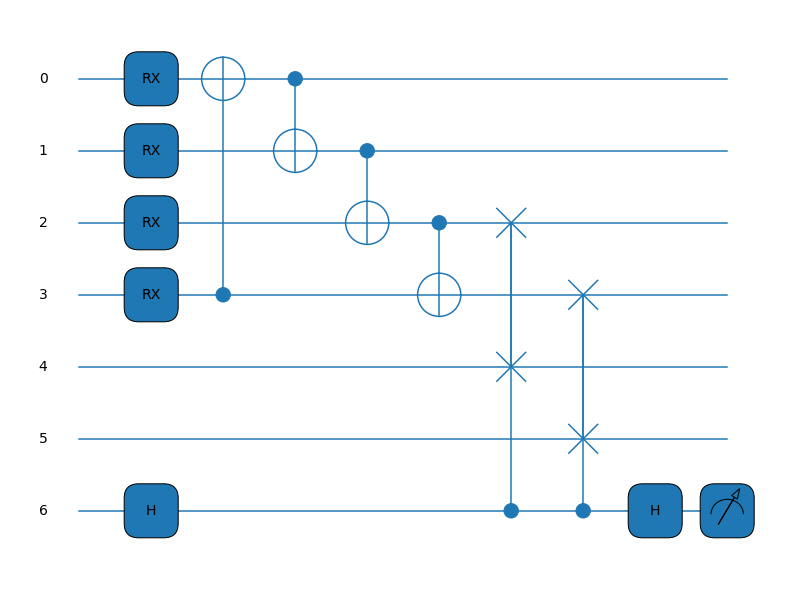

In [16]:
fig, ax = qml.draw_mpl(circuit)(np.ones(DRCs*4*num_params_single_layer),data)
fig.show()

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [8]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

In [9]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2],1))

x_train_threes = x_train_threes.reshape((x_train_threes.shape[0],x_train_threes.shape[1],x_train_threes.shape[2],1))
x_test_threes = x_test_threes.reshape((x_test_threes.shape[0],x_test_threes.shape[1],x_test_threes.shape[2],1))

In [10]:
x_train_small = tf.image.resize(x_train, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_small = tf.image.resize(x_test, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

x_train_3_small = tf.image.resize(x_train_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_3_small = tf.image.resize(x_test_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

2022-08-08 12:11:44.392271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-08 12:11:44.392294: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-08 12:11:44.392313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-08-08 12:11:44.392542: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


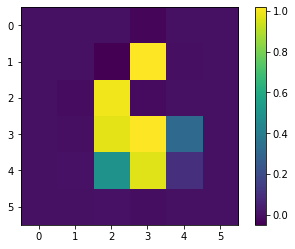

In [11]:
plt.imshow(x_train_small[3].reshape((x_train_small.shape[1],x_train_small.shape[2])))
plt.colorbar()

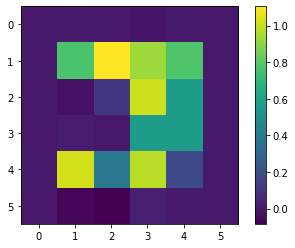

In [12]:
plt.imshow(x_train_3_small[3].reshape((x_train_3_small.shape[1],x_train_3_small.shape[2])))
plt.colorbar()

In [13]:
x_train_small = x_train_small.reshape(x_train_small.shape[0],INPUT_DATA_SIZE*INPUT_DATA_SIZE)
x_test_small = x_test_small.reshape(x_test_small.shape[0],INPUT_DATA_SIZE*INPUT_DATA_SIZE)

x_train_3_small = x_train_3_small.reshape(x_train_3_small.shape[0],INPUT_DATA_SIZE*INPUT_DATA_SIZE)
x_test_3_small = x_train_3_small.reshape(x_train_3_small.shape[0],INPUT_DATA_SIZE*INPUT_DATA_SIZE)

In [14]:
LAYERS = 5

def cost_batch(params, batch):
    loss = 0.0
    for i in batch:
        f = circuit(params, i)
        loss = loss + (1 - f) ** 2
    return loss / len(batch)

def cost(params):
    loss = 0.0
    for i in range(len(x_train)):
        f = circuit(params, x_train[i])
        loss = loss + (1 - f) ** 2
    return loss / len(x_train)

def cost_sample(params, single_sample):
    return (1 - circuit(params, single_sample)) ** 2

In [15]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In [16]:
learning_rate = 0.01
epochs = 10
batch_size = 20 

In [17]:
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
#opt = qml.QNGOptimizer(learning_rate)
# opt = GradientDescentOptimizer(learning_rate)

In [18]:
weight_shapes = {"weights": (DRCs*4*num_params_single_layer)}
params = np.random.uniform(size=weight_shapes["weights"], requires_grad=True)

In [19]:
params.shape

(312,)

In [20]:
x_train_small = x_train_small[:1200]
x_test_small = x_test_small[:1200]
x_train_3_small = x_train_3_small[:1200]
x_test_3_small = x_test_3_small[:1200]

In [21]:
start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(x_train_small, batch_size=batch_size)):  
    #for j, sample in enumerate(x_train_small):        
        #sample = np.array(sample, requires_grad=False)
        #cost_fn = lambda p: cost_sample(p, sample)
        cost_fn = lambda p: cost_batch(p, Xbatch)
        #metric_fn = lambda p: qml.metric_tensor(circuit, approx="block-diag")(p, sample)
        params = opt.step(cost_fn, params)#, metric_tensor_fn=metric_fn)
        print(j, end="\r")
        if j % 20 == 0:
            end_b = time.time()
            loss = cost_batch(params,Xbatch)
            print(f"Step: {j} | Loss: {loss:.3} | avg step time {(end_b - start_b) / 100 :.3}")
            start_b = time.time()

    loss = cost_batch(params,x_train_small)
    val_loss = cost_batch(params, x_test_small)
    
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3} | Val Loss {val_loss:.3}")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs with {LAYERS} layers: {end - start}")

Step: 0 | Loss: 0.371 | avg step time 0.401
Step: 20 | Loss: 0.101 | avg step time 9.32
Step: 40 | Loss: 0.0358 | avg step time 9.73
Epoch: 0 | Loss: 0.0175379460767201 | Val Loss 0.020324175772446454
Step: 0 | Loss: 0.00915 | avg step time 0.402
Step: 20 | Loss: 0.0138 | avg step time 7.46
Step: 40 | Loss: 0.00382 | avg step time 7.31
Epoch: 1 | Loss: 0.0035518785261736425 | Val Loss 0.004169657587733514
Step: 0 | Loss: 0.00169 | avg step time 0.349
Step: 20 | Loss: 0.00306 | avg step time 7.56
Step: 40 | Loss: 0.0011 | avg step time 7.74
Epoch: 2 | Loss: 0.0013146460190783713 | Val Loss 0.0015998438352657026
Step: 0 | Loss: 0.000614 | avg step time 0.478
Step: 20 | Loss: 0.00121 | avg step time 8.84
Step: 40 | Loss: 0.000496 | avg step time 8.62
Epoch: 3 | Loss: 0.0006491463314425162 | Val Loss 0.0008141393657764612
Step: 0 | Loss: 0.000291 | avg step time 0.335
Step: 20 | Loss: 0.000625 | avg step time 7.8
Step: 40 | Loss: 0.000269 | avg step time 8.65
Epoch: 4 | Loss: 0.00037596131

In [25]:
pred_six = np.array([circuit(params,i) for i in x_test_small])
np.mean(pred_six)
print("Median six reconstruciton fidelities: ",np.median(pred_six))

pred_three = np.array([circuit(params,i) for i in x_test_3_small])
np.mean(pred_three)
print("Median three reconstruciton fidelities: ",np.median(pred_three))

Median six reconstruciton fidelities:  0.9935792980215437
Median three reconstruciton fidelities:  0.9855457529676315


(array([  1.,   2.,   0.,   0.,   2.,   0.,   0.,   4.,   1.,   1.,   1.,
          2.,   3.,   0.,   5.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   5.,   0.,   1.,   1.,   2.,
          1.,   0.,   4.,   2.,   5.,   4.,   6.,   8.,   7.,   8.,  15.,
         35.,  52., 115., 216., 383., 304.]),
 array([0.60304026, 0.61096234, 0.61888442, 0.62680649, 0.63472857,
        0.64265064, 0.65057272, 0.6584948 , 0.66641687, 0.67433895,
        0.68226102, 0.6901831 , 0.69810517, 0.70602725, 0.71394933,
        0.7218714 , 0.72979348, 0.73771555, 0.74563763, 0.75355971,
        0.76148178, 0.76940386, 0.77732593, 0.78524801, 0.79317008,
        0.80109216, 0.80901424, 0.81693631, 0.82485839, 0.83278046,
        0.84070254, 0.84862461, 0.85654669, 0.86446877, 0.87239084,
        0.88031292, 0.88823499, 0.89615707, 0.90407915, 0.91200122,
        0.9199233 , 0.92784537, 0.93576745, 0.94368952, 0.9516116 ,
        0.95953368, 0.96745575, 0.97537783, 0.

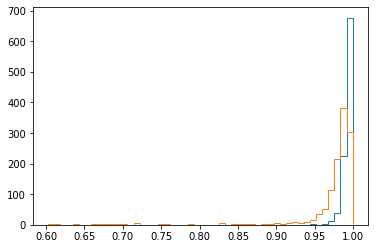

In [27]:
bins = np.histogram(np.hstack((pred_six.reshape((pred_six.shape[0],)), pred_three.reshape((pred_three.shape[0],)))), bins=50)[1]
plt.hist(pred_six, histtype='step', label="sixes",bins=bins)
plt.hist(pred_three, histtype='step', label="threes",bins=bins)

AUC:  0.8032898399443285


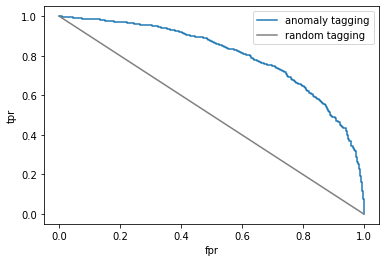

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

bce_background = 1-pred_six
bce_signal = 1-pred_three

y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
y_pred = np.append(bce_background, bce_signal)
auc = roc_auc_score(y_true, y_pred)

print("AUC: ", auc)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
tnr = 1 - fpr
x = np.linspace(0,1,50)
y_rnd = 1 - x
plt.plot(tnr,tpr, label="anomaly tagging")
plt.plot(x,y_rnd, label="random tagging", color='grey')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

0.7279888785912882


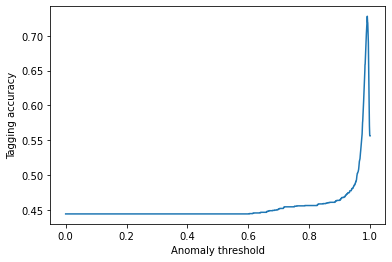

In [24]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_six > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_three < T)
    acc = (num_six_right + num_three_right)/(len(pred_six) + len(pred_three))
    return acc

Ts = np.linspace(0,1,2000)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.ylabel("Tagging accuracy")
plt.xlabel("Anomaly threshold")
plt.plot(Ts, accs)  